# Handwritten Artificial Neural Network
> Example on MNIST dataset.

In [1]:
import numpy as np
from matplotlib import pyplot
import MNISTtools

* Load MNIST data

In [2]:
xtrain, ltrain = MNISTtools.load(dataset="training")
xtest, ltest = MNISTtools.load(dataset="testing")
print(f'The size of trainning set is {xtrain.shape[1]}')
print(f'The feature dimension is {xtrain.shape[0]}.')
print(f'The shape of input images is {xtrain.shape} and the shape of labels is {ltrain.shape}.')

The size of trainning set is 60000
The feature dimension is 784.
The shape of input images is (784, 60000) and the shape of labels is (60000,).


* Normalize input data
* Translate labels to fit into the network

In [3]:
def normalize_MNIST_images(x):
    x = x.astype(np.float32)
    MAX = np.max(x)
    MIN = np.min(x)
    x = - 1 + 2 * ( x - MIN) / ( MAX - MIN)
    return x

def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[[ind for ind in lbl], np.arange(lbl.size)] = 1
    return d

xtrain = normalize_MNIST_images(xtrain)
xtest = normalize_MNIST_images(xtest)
dtrain = label2onehot(ltrain)
dtest = label2onehot(ltest)
print('The shape of the one-hot codes is {}.'.format(np.shape(dtrain)))

The shape of the one-hot codes is (10, 60000).


* Define Softmax and ReLu function
* Define Loss Metric

In [4]:
def softmax(a):
    d = np.exp(a - a.max(axis=0))
    return d / np.sum(d,axis=0)

def softmaxp(a, e):
    g = softmax(a)
    return g * e - np.sum(g * e, axis=0) * g

def relu(a):
    return np.maximum(a,0)
    
def relup(a, e):
    return (a > 0) * 1 * e

def eval_loss(y, d):
    return np.sum( -d * np.log(y)) / y.size

def eval_perfs(y, lbl):
    dlbl = label2onehot(lbl)
    pred = np.max( y * dlbl, axis=0)
    comp = np.max( y, axis=0)
    return np.sum(pred != comp) / np.size(lbl)

* Structure network
> Using He and Xavier initializations  
ReLu as activity function

In [5]:
def init_fc(dim_in, dim_out, internal=[512]):
    layer = len(internal)+1
    internal.insert(0, dim_in)
    internal.append(dim_out)
    W = []
    b = []
    for i in range(layer):
        W_add = np.random.randn(internal[i+1], internal[i]) / np.sqrt((internal[i]+1.)/2.)
        b_add = np.random.randn(internal[i+1], 1) / np.sqrt((internal[i]+1.)/2.)
        W.append(W_add)
        b.append(b_add)
    return W,b

def forward(x, W, b):
    layer = len(W)
    h = x
    cache = []
    for i in range(layer):
        a = W[i] @ h + b[i]
        cache.append(a)
        h = relu(a)
    y = softmax(cache[-1])
    return y,cache

def backward(x, d, W, b, gamma=.05):
    layer = len(W)
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    y,cache = forward(x, W, b)
    # Error evaluation
    e = -d / y
    # Backward phase
    delta = [softmaxp(cache[-1], e)]
    for i in range(layer-1,0,-1):
        add = relup(cache[i-1], W[i].T @ delta[-1])
        delta.append(add)
    delta = delta[::-1]
    # Gradient update
    W[0] = W[0] - gamma * delta[0] @ x.T
    b[0] = b[0] - gamma * delta[0].sum( axis=1, keepdims=True)
    for i in range(1,layer):
        W[i] = W[i] - gamma * delta[i] @ cache[i-1].T
        b[i] = b[i] - gamma * delta[i].sum( axis=1, keepdims=True)
    return W,b

* Train the network for MNIST classification
> Using batches

In [6]:
def backprop_batch(x, d, v, d_v, W, b, T=10, B=100, gamma=.05):
    N = x.shape[1]
    NB = int((N+B-1)/B)
    lbl = onehot2label(d)
    lbl_v = onehot2label(d_v)
    loss = []
    perfs = []
    val = []
    for t in range(T):
        print(t+1,T)
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            batch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            W,b = backward(x[:,batch_indices], d[:,batch_indices], W, b, gamma)
            
        y,_ = forward(x, W, b)
        y_v,_ = forward(v, W, b)
        loss.append(eval_loss(y,d))
        perfs.append(eval_perfs(y,lbl))
        val.append(eval_perfs(y_v,lbl_v))
        
    print ("Final Loss:", loss[-1])
    print (f'Final Percentage of Training Errors: {100*perfs[-1]:.2f} %')
    axis_x = np.arange(1,len(loss)+1)
    pyplot.subplot(5,1,1)
    pyplot.plot(axis_x,loss)
    pyplot.title('Loss')
    pyplot.show
    pyplot.subplot(5,1,3)
    pyplot.plot(axis_x,perfs)
    pyplot.title('Perfs')
    pyplot.show
    pyplot.subplot(5,1,5)
    pyplot.plot(axis_x,val)
    pyplot.title('Val')
    pyplot.show
    return W,b

1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30
30 30
Final Loss: 2.4314342196037217e-05
Final Percentage of Training Errors: 0.00 %


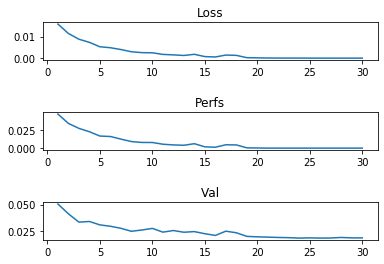

In [7]:
dim_in = xtrain.shape[0]
internal = [512,256,128,64,32]
dim_out = dtrain.shape[0]
W,b = init_fc(dim_in, dim_out, internal)
W,b = backprop_batch(xtrain, dtrain, xtest, dtest, W, b, T=30, B=100, gamma=.05)

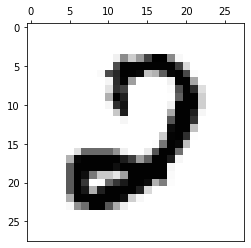

The prediction is: 2


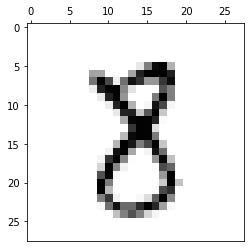

The prediction is: 8


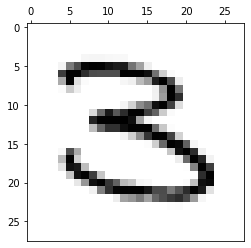

The prediction is: 3


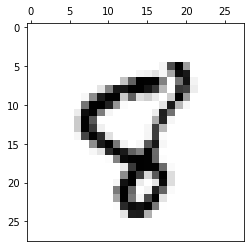

The prediction is: 8


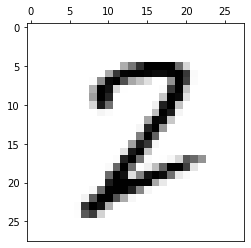

The prediction is: 2


In [8]:
indcies = range(400,405)
image=xtest[:, indcies]
d,_ = forward(image,W,b)
lb = onehot2label(d)
for i,ind in enumerate(indcies):
    MNISTtools.show(xtest[:, ind])
    print('The prediction is:', lb[i])